## Dataset Prep

In [1]:
import pandas as pd
import numpy as np
import os
import re
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, SpatialDropout1D
from keras.utils import np_utils, to_categorical
from tensorflow.keras import activations
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotion,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [4]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,disgust,/kaggle/input/cremad/AudioWAV//1028_TSI_DIS_XX...
1,happy,/kaggle/input/cremad/AudioWAV//1075_IEO_HAP_LO...
2,happy,/kaggle/input/cremad/AudioWAV//1084_ITS_HAP_XX...
3,disgust,/kaggle/input/cremad/AudioWAV//1067_IWW_DIS_XX...
4,disgust,/kaggle/input/cremad/AudioWAV//1066_TIE_DIS_XX...


In [5]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

,Emotion,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [6]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

,Emotion,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [7]:
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(12162, 2)

In [8]:
%matplotlib inline

plt.style.use("ggplot")

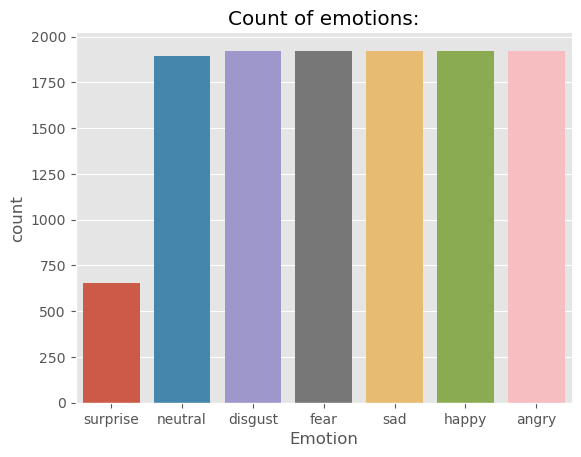

In [9]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

## Viewing certain audio spectograms

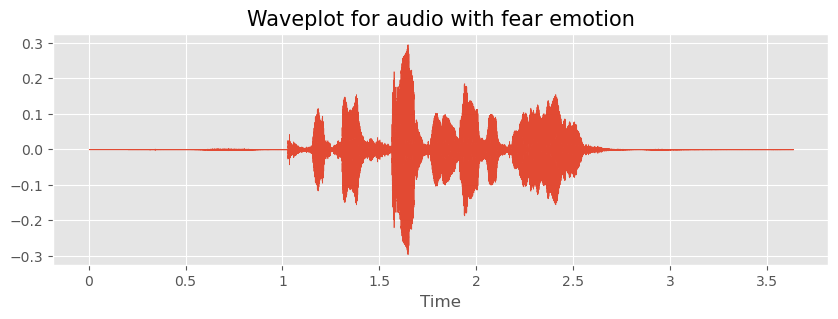

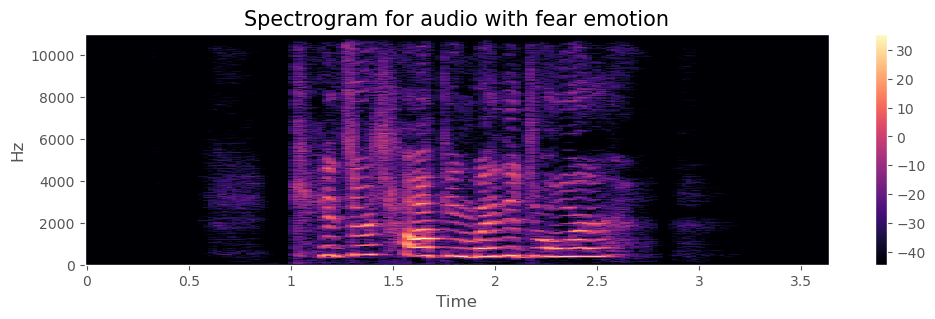

In [11]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


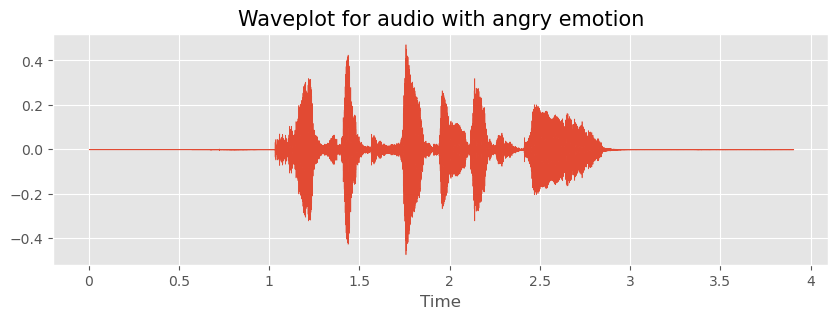

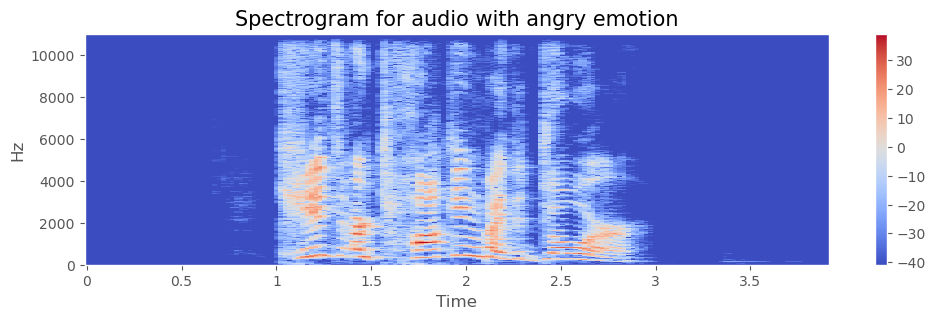

In [12]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

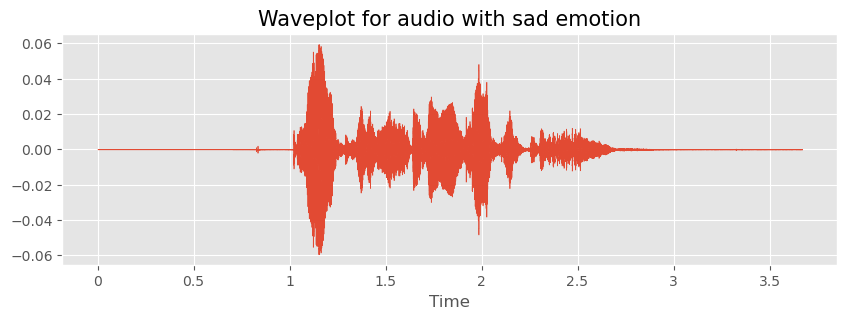

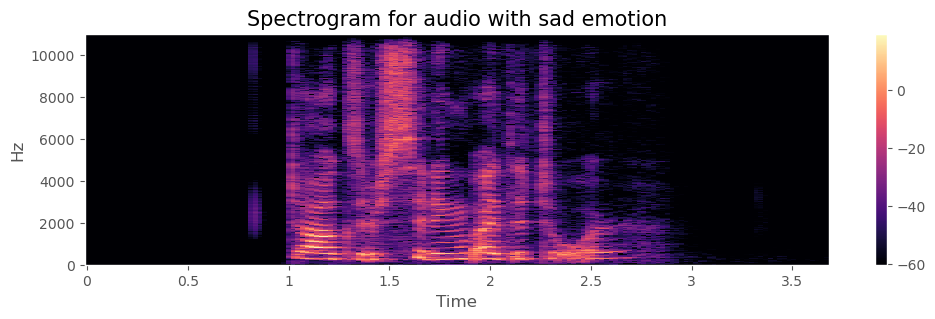

In [13]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [14]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [15]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

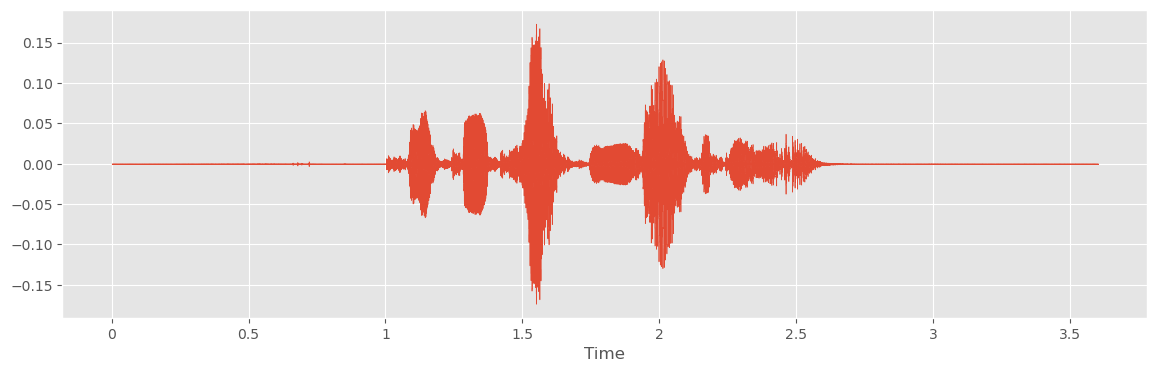

In [16]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(data, sr=sampling_rate)
Audio(path)

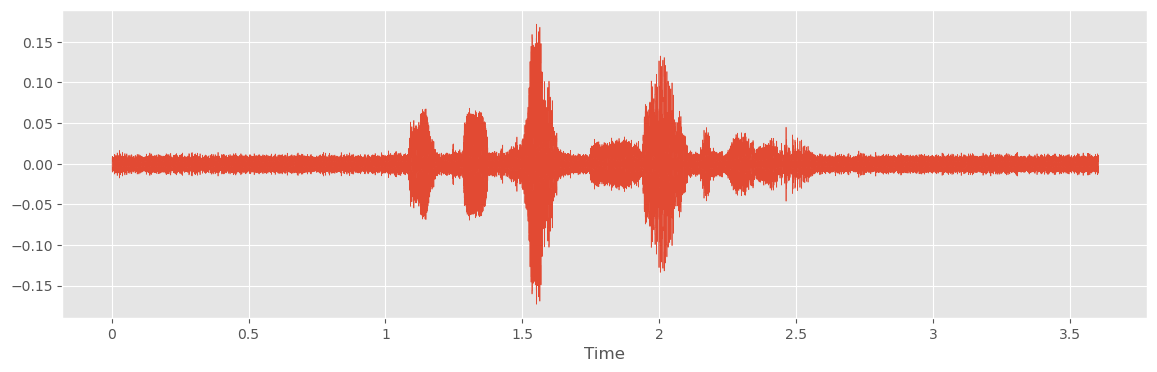

In [17]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)

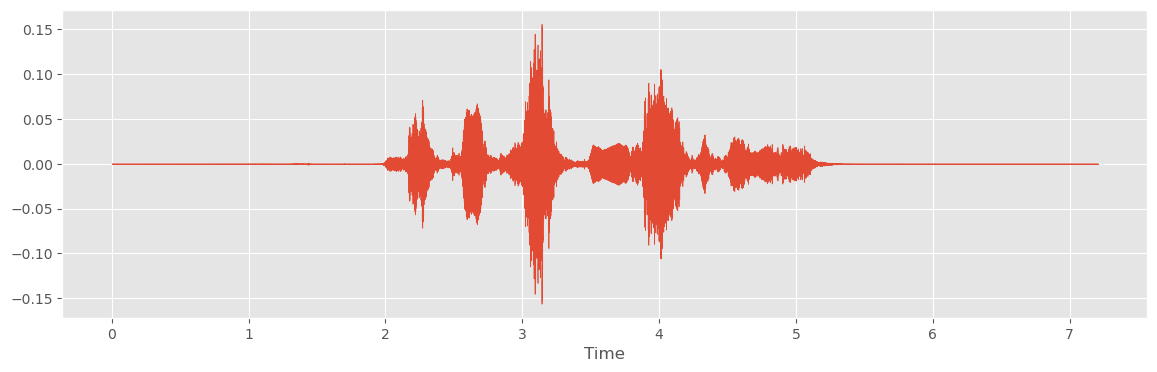

In [18]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

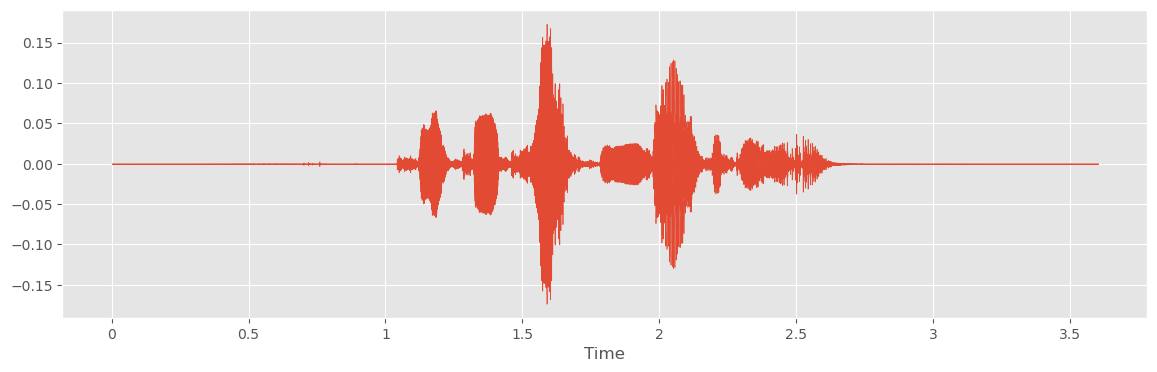

In [19]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)

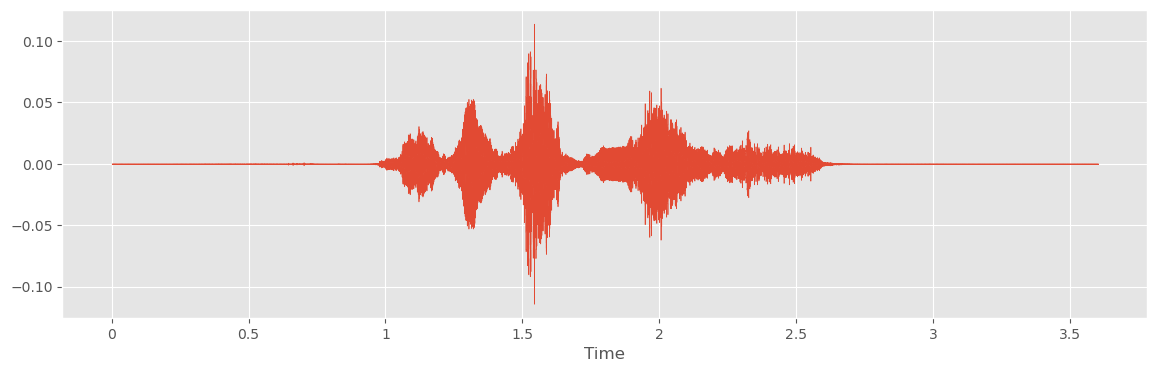

In [20]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

## Feature Extraction

In [21]:
n_fft = 2048
hop_length = 512

In [22]:
# def chunks(data, frame_length, hop_length):
#     for i in range(0, len(data), hop_length):
#         yield data[i:i+frame_length]

# # Zero Crossing Rate
# def zcr(data, frame_length=2048, hop_length=512):
#     zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
#     return np.squeeze(zcr)


# def energy(data, frame_length=2048, hop_length=512):
#     en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
#     return en / frame_length


# def rmse(data, frame_length=2048, hop_length=512):
#     rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
#     return np.squeeze(rmse)


# def entropy_of_energy(data, frame_length=2048, hop_length=512):
#     energies = energy(data, frame_length, hop_length)
#     energies /= np.sum(energies)

#     entropy = 0.0
#     entropy -= energies * np.log2(energies)
#     return entropy


# def spc(data, sr, frame_length=2048, hop_length=512):
#     spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
#     return np.squeeze(spectral_centroid)


# # def spc_entropy(data, sr):
# #     spc_en = spectral_entropy(data, sf=sr, method="fft")
# #     return spc_en

# def spc_flux(data):
#     isSpectrum = data.ndim == 1
#     if isSpectrum:
#         data = np.expand_dims(data, axis=1)

#     X = np.c_[data[:, 0], data]
#     af_Delta_X = np.diff(X, 1, axis=1)
#     vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

#     return np.squeeze(vsf) if isSpectrum else vsf


# def spc_rollof(data, sr, frame_length=2048, hop_length=512):
#     spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
#     return np.squeeze(spcrollof)


# def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
#     stft = np.abs(librosa.stft(data))
#     chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
#     return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


# def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
#     mel = librosa.feature.melspectrogram(y=data, sr=sr)
#     return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

# def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
#     mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
#     return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

### Using mfcc as the primary feature

In [33]:
def extract_features(signal, fs, mfcc_len: int=39, mean_signal_length: int=100000):
    """
    file_path: Speech Signal Folder
    mfcc_len: MFCC Coefficient Length
    mean_signal_length: MFCC feature average length
    """
    # signal, fs = librosa.load(file_path)
    s_len=len(signal)
    if s_len<mean_signal_length:
        pad_len=mean_signal_length-s_len
        pad_rem = pad_len%2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len+pad_rem), 'constant', constant_values=0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    mfcc = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=39)
    mfcc = (mfcc.T)
    feature = mfcc
    return feature   

def get_features(path):
    data, sample_rate = librosa.load(path)
     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = []
    result.append(np.array(res1))

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result.append(np.array(res2))
#     result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result.append(np.array(res3))
#     result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
#     result = np.vstack((result, res3)) # stacking vertically
    result.append(np.array(res3))

    return result

def get_features_test(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    return result

In [23]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)
print(type(path))

<class 'str'>


In [24]:
df

,Emotion,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
...,...,...
475,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
476,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
477,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
478,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


### Data Preparation

In [25]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
train.shape, test.shape

((9729, 2), (2433, 2))

In [27]:
# Feature Extraction for Test Data
X_test, Y_test = [], []
print("Feature Processing Started")
for path, emotion, ind, in zip(test.Path, test.Emotion, range(test.Path.shape[0])):
    features = get_features_test(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    X_test.append(features)
    Y_test.append(emotion)   
print("Done.")

Feature Processing Started
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
Done.


In [33]:
len(X_test)

2433

In [42]:
X_test = np.array(X_test)
X_test.shape

(2433, 196, 39)

In [ ]:
# Feature Extraction for Training Data
X, Y = [], []
print("Feature Processing Started")
for path, emotion, ind, in zip(train.Path, train.Emotion, range(train.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for i in features:
        X.append(i)
        Y.append(emotion)   
print("Done.")

In [36]:
X_train = np.array(X)
X_train.shape

(12, 196, 39)

In [ ]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
onehot_encoder = OneHotEncoder(sparse=False)
Y_train = onoehot_encoder.fit_transform(np.array(Y).reshape(-1, 1))
Y_test = onehot_encoder.fit_transform(np.array(Y_test).reshape(-1, 1))

In [38]:
Y_train.shape, Y_test.shape

(2433, 7)

In [64]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = Y_test.shape[1]

In [ ]:
# Callbacks
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5, verbose=1,
                              restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Model - 1 (Combination of LSTM and CNN - Gives an accuracy of around 58%)

In [69]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Bidirectional

# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


### Model 2 - CNN

In [ ]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=input_shape)) 
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(num_classes)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

### Model 3 - CNN

In [ ]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

### Model 4 - Bidirectional LSTM

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### Model 4 - LSTM

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### Model 5 - CNN

In [ ]:
# Define the Conv1D model
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(input_length, input_channels)))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### Tried Using GridSearchCV to find the best hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
def create_model(optimizer='adam', activation='relu', hidden_units=128, dropout_rate=0.5):
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=True), input_shape=input_shape))
    model.add(Conv1D(hidden_units, 3, activation=activation))
    model.add(MaxPooling1D(2))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(hidden_units, 3, activation=activation))
    model.add(MaxPooling1D(2))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(hidden_units, 3, activation=activation))
    model.add(MaxPooling1D(2))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(hidden_units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the hyperparameters to search over
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'sigmoid'],
    'hidden_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.5, 0.8]
}

# Create the KerasClassifier wrapper for Keras models
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_test, Y_test)

# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_test, Y_test), callbacks=[earlystopping, learning_rate_reduction])

### Model Score

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Saving the Model

In [ ]:
# Save model and weights
model_name = 'SER_Modle.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json1.json", "w") as json_file:
    json_file.write(model_json)